# CONEXION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LIBRERIAS Y CARGA DATA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random

# Leer archivo
df = pd.read_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/TESIS/DATA.xlsx')

# Parsear fechas

meses_es = {
    'ENE': 'Jan', 'FEB': 'Feb', 'MAR': 'Mar', 'ABR': 'Apr',
    'MAY': 'May', 'JUN': 'Jun', 'JUL': 'Jul', 'AGO': 'Aug',
    'SEP': 'Sep', 'OCT': 'Oct', 'NOV': 'Nov', 'DIC': 'Dec'
}
for esp, eng in meses_es.items():
    df['Períodos de tiempo'] = df['Períodos de tiempo'].str.replace(esp, eng, regex=False)


df['Períodos de tiempo'] = pd.to_datetime(df['Períodos de tiempo'], format='%b %Y')
df = df.sort_values(by='Períodos de tiempo')

# Filtrar un producto (puedes iterar sobre varios)
producto_id = df['Producto'].unique()[0]
df_producto = df[df['Producto'] == producto_id].copy()
df_producto.set_index('Períodos de tiempo', inplace=True)



# SARIMA

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few 

Top 5 combinaciones:
         order seasonal_order  avg_harmonic_wmape
584  (2, 1, 0)  (1, 2, 2, 12)            0.001722
575  (2, 1, 0)  (0, 2, 2, 12)            0.001722
593  (2, 1, 0)  (2, 2, 2, 12)            0.001722
591  (2, 1, 0)  (2, 2, 0, 12)            0.001722
592  (2, 1, 0)  (2, 2, 1, 12)            0.001722


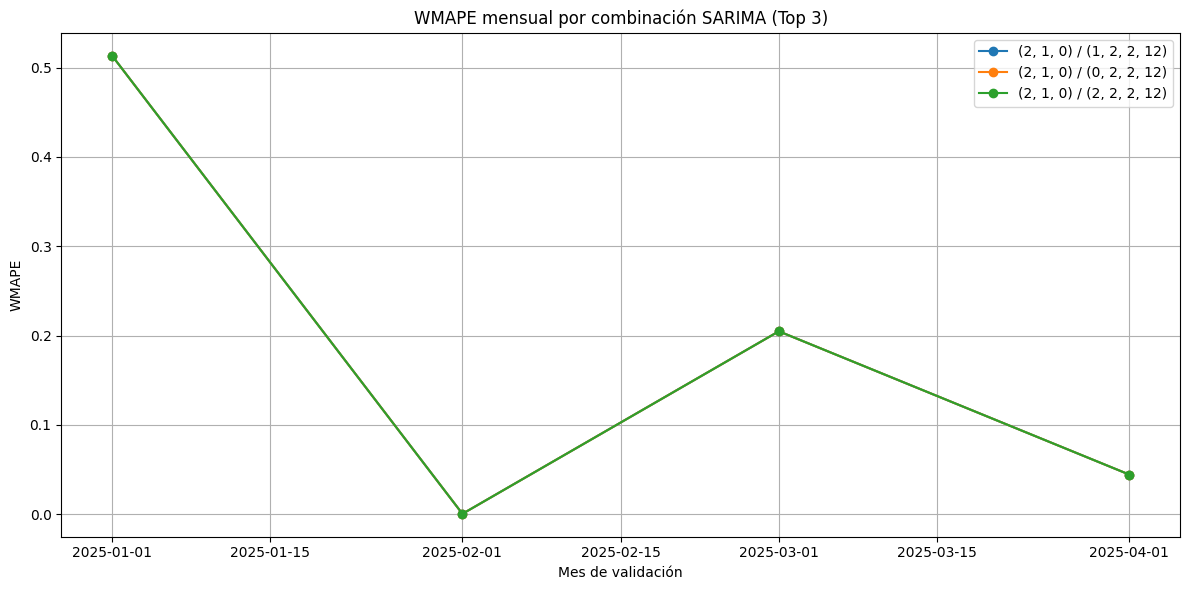

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import hmean

# Preparar datos
y_full = df_producto['Histórico de Ventas Sell-Out']
cutoff = pd.to_datetime("2024-12-01")
validation_months = pd.date_range(start="2025-01-01", end=y_full.index.max(), freq='MS')

# Hiperparámetros
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = 12

param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q))

results = []
forecast_dict = {}  # <- Guardará los pronósticos mensuales

for order in param_combinations:
    for seasonal in seasonal_combinations:
        seasonal_order = seasonal + (s,)
        wmape_scores = []
        monthly_forecast = []

        try:
            for i, val_date in enumerate(validation_months):
                train_end = val_date - pd.DateOffset(months=1)
                train_series = y_full[:train_end]
                test_value = y_full[val_date]

                model = SARIMAX(train_series,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                result = model.fit(disp=False)
                forecast = result.forecast(steps=1)

                pred = forecast.iloc[0]
                actual = test_value
                wmape = np.abs(actual - pred) / np.abs(actual)
                wmape_scores.append(wmape)
                monthly_forecast.append(pred)

            # Guardar si completó todos los meses
            if len(wmape_scores) == len(validation_months):
                avg_wmape = hmean(wmape_scores)
                results.append({
                    'order': order,
                    'seasonal_order': seasonal_order,
                    'avg_harmonic_wmape': avg_wmape,
                    'monthly_wmapes': wmape_scores
                })
                forecast_dict[(order, seasonal_order)] = monthly_forecast

        except Exception as e:
            # Falló, registrar pero no guardar pronóstico
            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'avg_harmonic_wmape': np.nan,
                'error': str(e)
            })

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='avg_harmonic_wmape')

# Mostrar el top 5
print("Top 5 combinaciones:")
print(results_df[['order', 'seasonal_order', 'avg_harmonic_wmape']].head())

# Graficar errores WMAPE mensuales del top 3
top_n = 3
top_results = results_df.dropna().head(top_n)

plt.figure(figsize=(12, 6))
for idx, row in top_results.iterrows():
    label = f"{row['order']} / {row['seasonal_order']}"
    plt.plot(validation_months, row['monthly_wmapes'], marker='o', label=label)

plt.title('WMAPE mensual por combinación SARIMA (Top 3)')
plt.xlabel('Mes de validación')
plt.ylabel('WMAPE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Guardar pronósticos del mejor modelo en Excel
results_df.to_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/resultados_sarima.xlsx')

# LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import itertools
from scipy.stats import hmean

# Escalar datos
scaler = MinMaxScaler()
scaled_full = scaler.fit_transform(df_producto[['Histórico de Ventas Sell-Out']])

# Crear función para estructura LSTM
def create_lstm_data(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

# Rango de predicción
fechas_test = df_producto['2025-01':].index

# Grilla de hiperparámetros
window_sizes = [3, 6, 12]
n_units_list = [20, 50, 100]
n_epochs_list = [50, 100]
activations = ['relu', 'tanh']
batch_sizes = [8, 16]
optimizers = ['adam', 'rmsprop']

# Resultados
results = []

# Iterar combinaciones
for window_size, n_units, n_epochs, activation, batch_size, optimizer in itertools.product(
    window_sizes, n_units_list, n_epochs_list, activations, batch_sizes, optimizers):

    wmape_list = []

    for i in range(len(fechas_test)):
        fecha_final_train = fechas_test[i]
        df_train = df_producto[:fecha_final_train]

        # Preparar serie escalada con ventana expanding
        scaled_series = scaler.transform(df_train[['Histórico de Ventas Sell-Out']])

        if len(scaled_series) <= window_size:
            continue  # Evita series muy cortas

        X_train, y_train = create_lstm_data(scaled_series, window_size)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

        try:
            # Crear modelo
            model = Sequential()
            model.add(LSTM(n_units, activation=activation, input_shape=(window_size, 1)))
            model.add(Dense(1))
            model.compile(optimizer=optimizer, loss='mse')

            # Entrenar
            model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                      verbose=0, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

            # Pronóstico siguiente mes
            input_seq = scaled_series[-window_size:].reshape((1, window_size, 1))
            pred = model.predict(input_seq, verbose=0)[0][0]
            pred_inv = scaler.inverse_transform([[pred]])[0][0]

            actual = df_producto.loc[fecha_final_train, 'Histórico de Ventas Sell-Out']
            wmape = np.abs(actual - pred_inv) / np.abs(actual)
            wmape_list.append(wmape)

        except Exception as e:
            continue

    # Calcular promedio armónico WMAPE si hay suficientes datos
    if len(wmape_list) > 2:
        mean_wmape = hmean([w for w in wmape_list if w > 0])
        results.append({
            'window_size': window_size,
            'n_units': n_units,
            'n_epochs': n_epochs,
            'activation': activation,
            'batch_size': batch_size,
            'optimizer': optimizer,
            'harmonic_mean_wmape': mean_wmape
        })

# Mostrar mejores resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='harmonic_mean_wmape')
print(results_df.head())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 

     window_size  n_units  n_epochs activation  batch_size optimizer  \
9              3       20       100       relu           8   rmsprop   
31             3       50       100       tanh          16   rmsprop   
22             3       50        50       tanh          16      adam   
2              3       20        50       relu          16      adam   
127           12       50       100       tanh          16   rmsprop   

     harmonic_mean_wmape  
9               0.001521  
31              0.004519  
22              0.004992  
2               0.005773  
127             0.007491  


In [ ]:
# Guardar pronósticos del mejor modelo en Excel
results_df.to_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/resultados_lstm.xlsx')

In [ ]:
# Librerías
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import itertools

# Escalar datos
scaler = MinMaxScaler()
scaled = scaler.fit_transform(train[['Histórico de Ventas Sell-Out']])
test_scaled = scaler.transform(test[['Histórico de Ventas Sell-Out']])

# Función para crear estructura de datos LSTM
def create_lstm_data(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

# Hiperparámetros a evaluar
window_sizes = [3, 6, 12]
n_units_list = [20, 50, 100]
n_epochs_list = [50, 100, 200]
activations = ['relu', 'tanh']
batch_sizes = [8, 16]
optimizers = ['adam', 'rmsprop']

# Guardar mejor resultado
best_wmape = np.inf
best_model_config = None
best_preds = None

# Lista para guardar resultados de cada iteración
results_lstm = []

# Grid Search manual
for window_size, n_units, n_epochs, activation, batch_size, optimizer in itertools.product(
    window_sizes, n_units_list, n_epochs_list, activations, batch_sizes, optimizers):

    try:
        X_lstm, y_lstm = create_lstm_data(scaled, window_size)
        X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

        # Crear modelo
        model = Sequential()
        model.add(LSTM(n_units, activation=activation, input_shape=(window_size, 1)))
        model.add(Dense(1))
        model.compile(optimizer=optimizer, loss='mse')

        # Entrenar
        model.fit(X_lstm, y_lstm, epochs=n_epochs, batch_size=batch_size, verbose=0,
                  callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

        # Pronóstico paso a paso
        input_seq = scaled[-window_size:].copy()
        preds = []
        for _ in range(len(test)):
            input_reshaped = input_seq.reshape((1, window_size, 1))
            pred = model.predict(input_reshaped, verbose=0)[0][0]
            preds.append(pred)
            input_seq = np.append(input_seq[1:], [[pred]], axis=0)

        preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

        # Evaluación con WMAPE
        actuals = test['Histórico de Ventas Sell-Out'].values
        wmape = np.sum(np.abs(actuals - preds_inv)) / np.sum(np.abs(actuals))

        # Guardar cada resultado
        results_lstm.append({
            'window_size': window_size,
            'n_units': n_units,
            'n_epochs': n_epochs,
            'activation': activation,
            'batch_size': batch_size,
            'optimizer': optimizer,
            'wmape': wmape
        })

        # Guardar mejor configuración
        if wmape < best_wmape:
            best_wmape = wmape
            best_model_config = {
                'window_size': window_size,
                'n_units': n_units,
                'n_epochs': n_epochs,
                'activation': activation,
                'batch_size': batch_size,
                'optimizer': optimizer
            }
            best_preds = preds_inv

    except Exception as e:
        continue  # Ignora errores durante el entrenamiento

# Mostrar mejor configuración
print("Mejor configuración LSTM:")
print(best_model_config)
print(f"WMAPE: {best_wmape:.2%}")

# Guardar resultados en DataFrame
results_lstm_df = pd.DataFrame(results_lstm)

# Guardar resultados en Excel
results_lstm_df.to_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/resultados_lstm.xlsx', index=False)

# Guardar pronósticos del mejor modelo
pd.DataFrame({'forecast': best_preds}).to_excel(
    '/content/drive/MyDrive/MAESTRIA/CICLO 4/forecast_lstm.xlsx',
    index=False
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 

Mejor configuración LSTM:
{'window_size': 12, 'n_units': 100, 'n_epochs': 100, 'activation': 'tanh', 'batch_size': 16, 'optimizer': 'adam'}
WMAPE: 17.18%


# AUTOENCODER

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools

# Dataset de entrenamiento
series = train[['Histórico de Ventas Sell-Out']].values
scaler_auto = MinMaxScaler()
series_scaled = scaler_auto.fit_transform(series)

# Hiperparámetros a evaluar
pca_components_list = [1, 2, 3]
n_clusters_list = [2, 3, 4]
noise_levels = [0.01, 0.05, 0.1, 0.2]

# Guardar mejor resultado
best_rmse = np.inf
best_config = None
best_forecast = None

# Combinación de hiperparámetros
for n_comp, n_clusters, noise_std in itertools.product(pca_components_list, n_clusters_list, noise_levels):
    try:
        # PCA
        pca = PCA(n_components=n_comp)
        encoded = pca.fit_transform(series_scaled)

        # KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(encoded)

        # Tomar centroide del último punto como base
        cluster_centroid = kmeans.cluster_centers_[labels[-1]]

        # Simular próxima serie como perturbación del centroide
        np.random.seed(42)
        perturbed_series = np.tile(cluster_centroid, (12, 1)) + np.random.normal(0, noise_std, (12, n_comp))

        # Inversión de transformación PCA + escalado
        decoded_series = pca.inverse_transform(perturbed_series)
        forecast_series = scaler_auto.inverse_transform(decoded_series)
        forecast_values = forecast_series[:, 0]  # Tomamos la primera dimensión como serie

        # Evaluación con RMSE (solo si se conoce test real)
        rmse = np.sqrt(mean_squared_error(test[['Histórico de Ventas Sell-Out']], forecast_values))

        # Guardar mejor
        if rmse < best_rmse:
            best_rmse = rmse
            best_config = {'pca_components': n_comp, 'n_clusters': n_clusters, 'noise_std': noise_std}
            best_forecast = forecast_values

    except Exception as e:
        continue

# Resultados
print("Mejor configuración Autoencoder-like PCA+KMeans:")
print(best_config)
print(f"RMSE: {best_rmse:.2f}")

autoenc_resultado = best_forecast

Mejor configuración Autoencoder-like PCA+KMeans:
None
RMSE: inf


# ESTOCASTICO MULTIETAPAS

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import itertools

# Preparar datos
series = train['Histórico de Ventas Sell-Out'].values
test_series = test['Histórico de Ventas Sell-Out'].values

# Hiperparámetros a evaluar
window_sizes = [6, 12, 18]
n_simulations_list = [100, 500]
noise_factors = [1.0, 1.2, 1.5]

# Guardar mejor resultado
best_rmse = np.inf
best_config = None
best_forecast = None

# Búsqueda de combinaciones
for window, n_simulations, noise in itertools.product(window_sizes, n_simulations_list, noise_factors):
    try:
        # Estimar media y desviación estándar de ventana
        mu = np.mean(series[-window:])
        sigma = np.std(series[-window:]) * noise

        # Simulaciones y promedio
        np.random.seed(42)
        simulations = np.random.normal(mu, sigma, (n_simulations, 12))
        forecast_mean = simulations.mean(axis=0)

        # Evaluación
        rmse = np.sqrt(mean_squared_error(test_series, forecast_mean))

        # Guardar si es mejor
        if rmse < best_rmse:
            best_rmse = rmse
            best_config = {'window_size': window, 'n_simulations': n_simulations, 'noise_factor': noise}
            best_forecast = forecast_mean

    except Exception:
        continue

# Resultados
print("Mejor configuración Estocástico Multietapas:")
print(best_config)
print(f"RMSE: {best_rmse:.2f}")

stoch_resultado = best_forecast


Mejor configuración Estocástico Multietapas:
None
RMSE: inf


# RESULTADOS

In [ ]:
resultado_df = pd.DataFrame({
    'Fecha': pd.date_range(start='2025-01-01', periods=12, freq='MS'),
    'SARIMA': sarima_resultado.values,
    'LSTM': lstm_resultado,
    'AutoencoderCluster': autoenc_resultado,
    'Estocastico': stoch_resultado
})

resultado_df.to_excel('resultados_forecast.xlsx', index=False)


# SARIMAX

In [ ]:
import pandas as pd

# === 1. Leer archivos ===
df = pd.read_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/TESIS/DATA.xlsx')  # tu archivo original
calendario_df = pd.read_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/TESIS/CALENDARIO.xlsx')
macro_df = pd.read_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/TESIS/MACRO.xlsx')

# === 2. Normalizar meses a inglés para parsear fechas ===
meses_es = {
    'ENE': 'Jan', 'FEB': 'Feb', 'MAR': 'Mar', 'ABR': 'Apr',
    'MAY': 'May', 'JUN': 'Jun', 'JUL': 'Jul', 'AGO': 'Aug',
    'SEP': 'Sep', 'OCT': 'Oct', 'NOV': 'Nov', 'DIC': 'Dec'
}

for esp, eng in meses_es.items():
    df['Períodos de tiempo'] = df['Períodos de tiempo'].str.replace(esp, eng, regex=False)
    calendario_df['PERIODO'] = calendario_df['PERIODO'].str.replace(esp, eng, regex=False)
    macro_df['MES'] = macro_df['MES'].str.replace(esp, eng, regex=False)

# === 3. Parsear fechas ===
df['Períodos de tiempo'] = pd.to_datetime(df['Períodos de tiempo'], format='%b %Y')
calendario_df['PERIODO'] = pd.to_datetime(calendario_df['PERIODO'], format='%b %Y')
macro_df['MES'] = pd.to_datetime(macro_df['MES'], format='%b %Y')

# === 4. Filtrar un producto (ajusta si deseas más) ===
producto_id = df['Producto'].unique()[0]
df_producto = df[df['Producto'] == producto_id].copy()
df_producto = df_producto.sort_values('Períodos de tiempo')
df_producto.set_index('Períodos de tiempo', inplace=True)

# === 5. Renombrar columnas para merge ===
calendario_df.rename(columns={'PERIODO': 'Períodos de tiempo'}, inplace=True)
macro_df.rename(columns={'MES': 'Períodos de tiempo'}, inplace=True)

# === 6. Unir calendario y macro al dataframe de ventas ===
df_exog = df_producto.reset_index()
df_exog = df_exog.merge(calendario_df, on='Períodos de tiempo', how='left')
df_exog = df_exog.merge(macro_df, on='Períodos de tiempo', how='left')
df_exog.set_index('Períodos de tiempo', inplace=True)

# === 7. Definir serie de ventas y exógenas ===
y_full = df_exog['Histórico de Ventas Sell-Out']
exog_full = df_exog.drop(columns=['Producto', 'Histórico de Ventas Sell-Out'])

# Opcional: Escalar exógenas si es necesario
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# exog_full_scaled = pd.DataFrame(scaler.fit_transform(exog_full), index=exog_full.index, columns=exog_full.columns)


In [ ]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import hmean

# Suponiendo que ya tienes:
# y_full: serie de ventas indexada por fechas
# exog_full: DataFrame de variables exógenas indexado por fechas

# 1. Definir meses de validación
cutoff = pd.to_datetime("2024-12-01")
validation_months = pd.date_range(start="2025-01-01", end=y_full.index.max(), freq='MS')

# 2. Asegurarse de que exog_full tenga solo variables numéricas y sin NaN
exog_full = exog_full.select_dtypes(include=['number'])  # Solo columnas numéricas
exog_full = exog_full.fillna(method='ffill').fillna(method='bfill')  # Imputar faltantes si hay

# Validar índices
assert all(val in y_full.index for val in validation_months), "Fechas faltantes en y_full"
assert all(val in exog_full.index for val in validation_months), "Fechas faltantes en exog_full"

# 3. Definir combinaciones SARIMA
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = 12

param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q))

results = []
forecast_dict = {}

# 4. Loop principal
for order in param_combinations:
    for seasonal in seasonal_combinations:
        seasonal_order = seasonal + (s,)
        wmape_scores = []
        monthly_forecast = []

        try:
            for val_date in validation_months:
                train_end = val_date - pd.DateOffset(months=1)

                y_train = y_full[:train_end]
                X_train = exog_full[:train_end]
                X_test = exog_full.loc[[val_date]]  # debe ser DataFrame

                actual = y_full[val_date]

                model = SARIMAX(y_train,
                                exog=X_train,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                result = model.fit(disp=False)
                forecast = result.forecast(steps=1, exog=X_test)

                pred = forecast.iloc[0]
                wmape = np.abs(actual - pred) / np.abs(actual)
                wmape_scores.append(wmape)
                monthly_forecast.append(pred)

            if len(wmape_scores) == len(validation_months):
                avg_wmape = hmean(wmape_scores)
                results.append({
                    'order': order,
                    'seasonal_order': seasonal_order,
                    'avg_harmonic_wmape': avg_wmape,
                    'monthly_wmapes': wmape_scores
                })
                forecast_dict[(order, seasonal_order)] = monthly_forecast

        except Exception as e:
            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'avg_harmonic_wmape': np.nan,
                'error': str(e)
            })

# 5. Ordenar resultados
results_df = pd.DataFrame(results).sort_values(by='avg_harmonic_wmape')

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

In [ ]:
# Guardar pronósticos del mejor modelo en Excel
results_df.to_excel('/content/drive/MyDrive/MAESTRIA/CICLO 4/resultados_sarimax.xlsx')

In [ ]:
results_df

,order,seasonal_order,avg_harmonic_wmape,error
0,"(0, 0, 0)","(0, 0, 0, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
1,"(0, 0, 0)","(0, 0, 1, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
2,"(0, 0, 0)","(0, 0, 2, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
3,"(0, 0, 0)","(0, 1, 0, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
4,"(0, 0, 0)","(0, 1, 1, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
...,...,...,...,...
724,"(2, 2, 2)","(2, 1, 1, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
725,"(2, 2, 2)","(2, 1, 2, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
726,"(2, 2, 2)","(2, 2, 0, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
727,"(2, 2, 2)","(2, 2, 1, 12)",NaN,Pandas data cast to numpy dtype of object. Che...
